# Analyze Migration Areas

### Import Modules

In [2]:
# Import analysis packages
import os
import glob
import pandas as pd
import numpy as np

# Import plotting packages
import matplotlib as mpl
import seaborn as sns
import dabest

print("matplotlib v{}".format(mpl.__version__))
print("seaborn v{}".format(sns.__version__))
print("dabest v{}".format(dabest.__version__))

matplotlib v3.0.3
seaborn v0.9.0
dabest v0.2.4


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Assemble image data into a single dataframe

In [3]:
# Add analysis date here to apply to dataframe
analysis_date = '20190709'

path = os.path.abspath('')+'/CSVs/'
full_df = pd.DataFrame()
list_ = []

# For loop to bring in files and concatenate them into a single dataframe
for file_ in glob.glob(path + "/*.csv"):
    df = pd.read_csv(file_)
    # Determine Image name from file name
    df['Image'] = os.path.splitext(os.path.basename(file_))[0]
    # Split values in ROI label and Image name columns
    df['delete1'], df['ROI'], df['delete2'], df['delete3'] = zip(*df['Label'].map(lambda x: x.split(':')))
    (df['ExptDate'], df['Treatment'], df['Dose'], df['Stains'], df['Embryo'], 
        df['Somites'], df['ImageMag']) = zip(*df['Image'].map(lambda x: x.split('_')))
    list_.append(df)

full_df = pd.concat(list_)
full_df = full_df.drop(['Label', 'Mean', 'IntDen', 'RawIntDen', 'delete1', 'delete2', 'delete3'], axis=1)
full_df.head()

,,Area,Image,ROI,ExptDate,Treatment,Dose,Stains,Embryo,Somites,ImageMag
0,1,72103.705,"20180715_SMPD3MONC11m3bCat_0,8mM2ugul_Pax7GFP_...",CntlArea,20180715,SMPD3MONC11m3bCat,"0,8mM2ugul",Pax7GFP,Emb6,8ss,10x
1,2,23918.319,"20180715_SMPD3MONC11m3bCat_0,8mM2ugul_Pax7GFP_...",ExptArea,20180715,SMPD3MONC11m3bCat,"0,8mM2ugul",Pax7GFP,Emb6,8ss,10x
0,1,80452.846,"20180630_SMPD3MO_0,8mM_Pax7_Emb5_8ss_10x",CntlArea,20180630,SMPD3MO,"0,8mM",Pax7,Emb5,8ss,10x
1,2,47922.588,"20180630_SMPD3MO_0,8mM_Pax7_Emb5_8ss_10x",ExptArea,20180630,SMPD3MO,"0,8mM",Pax7,Emb5,8ss,10x
0,1,47346.082,"20181119_SMPD3MO_0,6mM_Pax7_Emb6_7ss_10x",CntlArea,20181119,SMPD3MO,"0,6mM",Pax7,Emb6,7ss,10x


### Parse, analyze, and output data

In [4]:
# Get a list of each treatment in full dataset
treatment_list = full_df.Treatment.unique()
treatment_list = treatment_list.tolist()

# Group dataframe by treatment
df_byTreatment = full_df.groupby(['Treatment', 'Image', 'ROI'])['Image', 'ROI', 'Area', 'Treatment'].mean()

# Initialize objects for full_results dataframe
full_results = pd.DataFrame()
results_list_ = []

# Loop trough treatments, performing each analysis and concatenating results into results_list_
for i in treatment_list:
    # Slice dataframe to process only embryos with given treatment
    df_treatment = pd.DataFrame(df_byTreatment.xs(i))

    # Extract Cntl and Expt areas
    area_cntl = df_treatment.xs('CntlArea', level='ROI')
    area_expt = df_treatment.xs('ExptArea', level='ROI')

    # Generate Expt/Cntl Area Ratios
    area_ratios = pd.DataFrame(area_expt / area_cntl)
    area_ratios.columns = ['Expt/Cntl Area']

    # Normalize all migration area values to mean of control group
    norm_cntl = area_cntl/(float(area_cntl.mean()))
    norm_cntl.columns = ['Norm Cntl Area']
    norm_expt = area_expt/(float(area_cntl.mean()))
    norm_expt.columns = ['Norm Expt Area']
    norm_areas = pd.concat([norm_cntl, norm_expt], axis=1, sort=False)

    # Combine processed values into single dataframe and append to results_list_
    area_cntl = pd.DataFrame(area_cntl)
    area_cntl.columns = ['Cntl Area']
    area_expt = pd.DataFrame(area_expt)
    area_expt.columns = ['Expt Area']
    df = pd.concat([area_cntl, area_expt, area_ratios, norm_cntl, norm_expt], axis=1, sort=True)
    results_list_.append(df)

# Combine results into dataframe, parse image information, and export as CSV file
full_results = pd.concat(results_list_, sort=False)
full_results = full_results.reset_index()
(full_results['Date'], full_results['Treatment'], full_results['Dose'], 
     full_results['Stains'], full_results['Embryo'], 
     full_results['Somites'], full_results['ImageMag']) = zip(*full_results['Image'].map(lambda x: x.split('_')))
full_results.to_csv(analysis_date + '_MigrationResults.csv')

full_results.head()

,Image,Cntl Area,Expt Area,Expt/Cntl Area,Norm Cntl Area,Norm Expt Area,Date,Treatment,Dose,Stains,Embryo,Somites,ImageMag
0,"20180715_SMPD3MONC11m3bCat_0,8mM2ugul_Pax7GFP_...",74016.874,36791.706,0.497072,1.149037,0.571154,20180715,SMPD3MONC11m3bCat,"0,8mM2ugul",Pax7GFP,Emb1,8ss,10x
1,"20180715_SMPD3MONC11m3bCat_0,8mM2ugul_Pax7GFP_...",50204.911,35216.774,0.701461,0.779381,0.546705,20180715,SMPD3MONC11m3bCat,"0,8mM2ugul",Pax7GFP,Emb2,7ss,10x
2,"20180715_SMPD3MONC11m3bCat_0,8mM2ugul_Pax7GFP_...",49913.257,24796.991,0.496802,0.774853,0.384948,20180715,SMPD3MONC11m3bCat,"0,8mM2ugul",Pax7GFP,Emb3,7ss,10x
3,"20180715_SMPD3MONC11m3bCat_0,8mM2ugul_Pax7GFP_...",72103.705,23918.319,0.331721,1.119337,0.371308,20180715,SMPD3MONC11m3bCat,"0,8mM2ugul",Pax7GFP,Emb6,8ss,10x
4,"20190603_SMPD3MONC11m3bCat_0,8mM2ugul_Cad6bRFP...",70442.204,28354.141,0.402516,1.093544,0.440169,20190603,SMPD3MONC11m3bCat,"0,8mM2ugul",Cad6bRFPGFPSnai2,Emb3,8ss,5x


### Analyze and plot data using DABEST
* Calculate effect size using a 5000, nonparametric, bootstrap 95% confidence interval
* Make a Gardner-Altman estimation plot

In [5]:
def plot_my_data(treatment, cntl_dataset, expt_dataset, yaxis_label, figname):
    """
    treatment = treatment to parse, str
    """
    # Isolate treatment alone
    dataset = full_results.loc[full_results['Treatment'] == treatment]
    dataset = dataset.copy(deep=True)
    dataset.rename(columns={'Norm Cntl Area':cntl_dataset,'Norm Expt Area':expt_dataset}, inplace=True)

    # Load data into DABEST as paired dataset
    data = dabest.load(dataset, idx=(cntl_dataset, expt_dataset), id_col='Image', paired=True)

    # Plot results
    fig1 = data.mean_diff.plot(
        #Set overall figure parameters
                fig_size=(3.5,3)                              
                ,dpi=150
                
        #Edit 0 line features, use matplotlib.Axes.hlines kwargs in dictionary format
                ,reflines_kwargs= {'linestyle':'dashed'      
                               ,'linewidth':.8
                               ,'color' : 'black'}
    
        #Set swarm plot parameters    
                ,swarm_label=(yaxis_label)
#                 ,swarm_ylim=(0,2)
                ,show_pairs=False                            #connect paired points? Yes (True), no (False)
#                 ,custom_palette={cntl_dataset:'#747575', expt_dataset:'#139604'}
                ,swarm_desat=1
                 ,group_summaries='mean_sd'                   #display mean+/-sd as bars next to swarm plots, depreciated keywork
                ,group_summaries_offset=0.15
                ,swarmplot_kwargs={'size':5}                 #swarmplot dot size
                ,group_summary_kwargs={'lw':3, 'alpha':0.8}   #summary line features

        #Set effect size plot parameters
                ,float_contrast=True                 #displays mean difference next to graph (True) or below graph (False)
                ,contrast_label='paired mean difference'
                ,es_marker_size=5 
                ,halfviolin_desat=1
                ,halfviolin_alpha=0.8
                ,violinplot_kwargs={'widths':0.5}
                             )

    # for j, ax in enumerate(fig1.axes):
    #     if j == 0: # the first axes which is the rawdata swarmplot.
    #         xticks_text = ['Control MO', 'SMase2 MO']
    #     else: # the contrast axes.
    #         xticks_text = ax.get_xticklabels()
    #     ax.set_xticklabels(xticks_text, 
    #                        rotation=45, horizontalalignment='center')
#     sns.set(font_scale=0.5)    
    
    fig1.tight_layout()
    fig1.savefig(figname + '.png', transparent=True, dpi=500)

    #Display statistical tests
    stats = data.mean_diff.statistical_tests
    
    return fig1, stats

,control,test,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Control MO,nSMase2 MO,mean difference,True,-0.416181,95,-0.613815,-0.251118,0.000006,1.0,8.934936e-09,8.29383


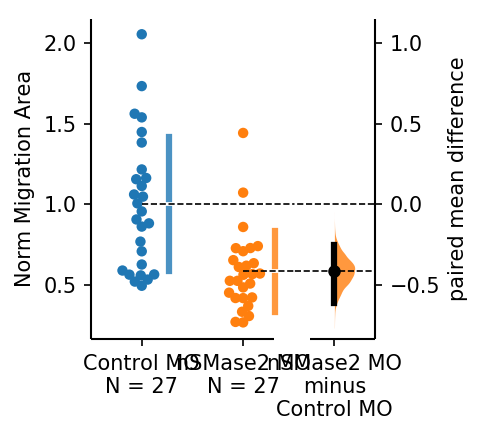

In [6]:
# nSMase2 MO vs Control MO
fig1, stats = plot_my_data('SMPD3MO', 'Control MO', 'nSMase2 MO', 'Norm Migration Area', 'nSMase2MO');
fig1
stats

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


,control,test,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Control gRNA,nSMase2 gRNA,mean difference,True,-0.251031,95,-0.442344,-0.030594,0.025062,2.0,0.007782,3.687492


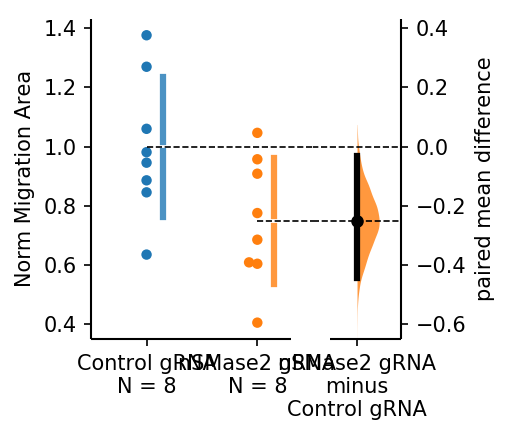

In [8]:
# nSMase2 CRISPR DNA vs Control CRISPR DNA
fig1, stats = plot_my_data('SMPD3gRNA1DNA', 'Control gRNA', 'nSMase2 gRNA', 'Norm Migration Area', 'nSMase2 gRNA');
fig1
stats

nSMase2 CRISPR (plasmid) Alone

nSMase2 CRISPR (RNP) Alone

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


,control,test,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Control gRNA,nSMase2 gRNA,mean difference,True,-0.196872,95,-0.459105,0.044153,0.01796,0.0,0.002256,5.084435


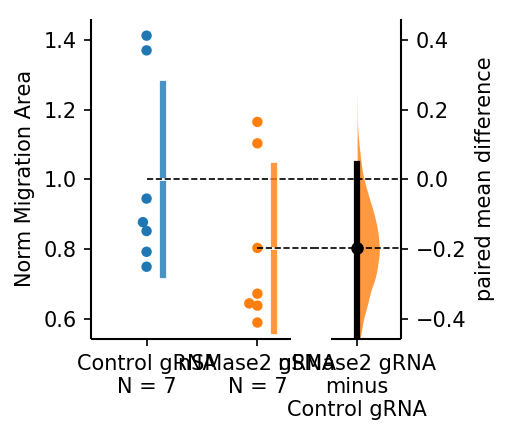

In [9]:
# nSMase2 CRISPR RNP vs Control CRISPR RNP
fig1, stats = plot_my_data('SMPD3gRNA1RNP', 'Control gRNA', 'nSMase2 gRNA', 'Norm Migration Area', 'nSMase2 gRNA');
fig1
stats

nSMase2 MO + NC1.1m3::Δ90-β-catenin-GFP

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


,control,test,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Control,βcat Rescue,mean difference,True,-0.560845,95,-0.709663,-0.415791,0.011719,0.0,0.000365,6.407146


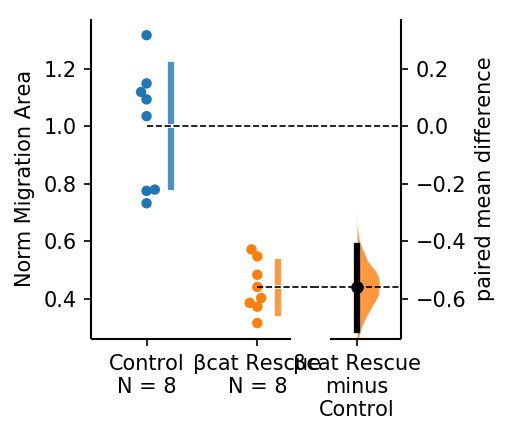

In [11]:
# Δ90-β-catenin rescue vs Control
fig1, stats = plot_my_data('SMPD3MONC11m3bCat', 'Control', 'βcat Rescue', 'Norm Migration Area', 'Δ90-βcat Rescue');
fig1
stats